#Description

Visualize uncertainity estimation using multiple neural networks. 

Data: simple regression model: Y = WX + eps. 

Model: a one-layer neural netwok. 

Plot: uncertainty with different number of neural networks 

#Theory

Based on the article: [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://arxiv.org/abs/1612.01474)

The training dataset consists of $N$ i.i.d. data points $\{x_n,y_n\}$. Given the input features $x$, we use a neural network (ensemble of networks) to model the probabilistic predictive distribution $p_θ(y|x)$ over the real-valued labels, where $θ$ are the parameters of the neural network (ensemble).

To start with, we randomly initialize weights of $M$ models and train them independently on the entire dataset (it was shown that random initialization of the parameters, along with random shuffling of the data points, was sufficient to obtain good performance in practice). By treating the observed value as a sample from a Gaussian distribution with the predicted mean $\mu(x)$ and variance $\sigma^2(x) > 0$, we minimize the negative log-likelihood criterion:
$$−\log p_\theta(y_n|x_n) = \frac{\log \sigma^2_\theta(x)}{2} + \frac{(y−\mu_{\theta(x)})^2}{ 2\sigma^2_\theta(x)} + \text{constant}.$$

Interestingly, adversarial training can be interpreted as a computationally efficient solution to smooth the predictive distributions by increasing the likelihood of the target around an $\epsilon$-neighborhood of the observed training examples. To create adversarial examples we use the fast gradient sign method, that generates an adversarial example as $x' = x + \epsilon \text{ sign} \nabla_x l(\theta,x,y)$.

We treat the ensemble as a uniformly-weighted mixture model and combine the predictions as $$p(y|x) = M^{-1} \sum \limits^M_{m=1} p_{\theta_m} (y|x,\theta_m).$$
Thus, the prediction is a mixture of Gaussian distributions. We further approximate the ensemble prediction as a Gaussian whose mean and variance are respectively the mean and variance of the mixture. The mean and variance of a mixture $M^{−1} \sum \mathcal{N}(\mu_{\theta_{m (x)}}, \sigma^2_{\theta_{m (x)}})$ are given by $\mu_∗(x) = M^{−1} \sum_m \mu_{\theta_{m (x)}}$ and $\sigma^2_∗(x) =  M^{−1} \sum_m (\sigma^2_{\theta_{m (x)}} + \mu^2_{\theta_{m (x)}})−\mu^2_∗(x)$ respectively.





#Experiments

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
from scipy import spatial
import pickle
import scipy

## Imports for plotting
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random, vmap, custom_jvp, grad
from jax.scipy.special import gammaln, digamma

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install -q flax
    import flax
from flax import linen as nn
from flax.training import train_state

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data

print("Device:", jax.devices()[0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


Device: TFRT_CPU_0


In [ ]:
from sklearn.datasets import make_regression

## Models

In [ ]:
class SimpleNet(nn.Module):
    hidden_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.hidden_dim)(x)
        x = nn.relu(x)
        mean = nn.Dense(features=1)(x)
        log_std = nn.Dense(features=1)(x)
        return mean, log_std

In [ ]:
def nll_loss(model, params, batch_x, batch_y):
    """
    Calculate negative log likelihood for gaussian distribution with given mean and variance
    """
    mean, log_std = model.apply({'params': params}, batch_x)
    loss = jnp.sum((batch_y - mean)**2 / (2 * jnp.exp(log_std)**2) + log_std + 0.5 * jnp.log(2 * math.pi))
    return loss

In [ ]:
class TrainerModule:
    def __init__(self, hidden_dim, train_loader, lr=1e-2, seed=42, eps=0.001):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.seed = seed
        self.eps = eps
        self.train_loader = train_loader

        self.exmp_x = next(iter(self.train_loader))[0]
        # Create empty model. Note: no parameters yet
        self.model = SimpleNet(hidden_dim=self.hidden_dim)
        # Create jitted training function
        self.create_functions()
        # Initialize model
        self.init_model()

    def create_functions(self):
        # Training function
        def train_step(state, batch_x, batch_y):
            #adversarial examples
            loss_adv = lambda batch_x: nll_loss(self.model, state.params, batch_x, batch_y)
            adv_grads = jax.grad(loss_adv)(batch_x)
            adv_x = batch_x + self.eps * jnp.sign(adv_grads)
            #combined loss
            x = jnp.concatenate([batch_x, adv_x])
            y = jnp.concatenate([batch_y, batch_y])
            loss_fn = lambda params: nll_loss(self.model, params, x, y)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            #optimizer step
            state = state.apply_gradients(grads=grads)
            return state, loss
        self.train_step = jax.jit(train_step)

    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng = jax.random.split(rng)
        params = self.model.init(init_rng, self.exmp_x)['params']
        # Initialize optimizer
        optimizer = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(self.lr)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, num_epochs=100, visualize=True):
        # Train model for defined number of epochs
        losses = []
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            loss = self.train_epoch(epoch=epoch_idx)
            losses.append(loss)

        if visualize:
          plt.figure(figsize=(5, 4))
          plt.plot(losses)
          plt.xlabel('epoch')
          plt.title('Training loss')
          plt.show()

    def train_epoch(self, epoch):
        # Train model for one epoch, and avg loss
        losses = []
        for batch_x, batch_y in self.train_loader:
            self.state, loss = self.train_step(self.state, batch_x, batch_y)
            losses.append(loss)
        avg_loss = np.mean(jax.device_get(losses))
        return avg_loss

## Linear dataset

In [ ]:
def numpy_collate(batch):
  data = []
  target = []
  for x, y in batch:
    data.append(x)
    target.append(y)
  return np.array(data), np.array(target).reshape(-1, 1)

In [ ]:
noise_std = 2
X, y, coef = make_regression(40, 1, noise=noise_std, coef=True)
train_data = data.TensorDataset(torch.tensor(X), torch.tensor(y))
train_loader = data.DataLoader(list(zip(X, y)), batch_size=16, shuffle=True, drop_last=True, collate_fn=numpy_collate)

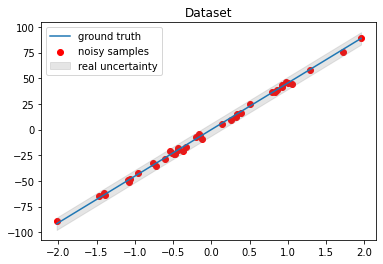

In [ ]:
grid = np.linspace(X.min(), X.max(), 1000)
plt.plot(grid, grid*coef, label='ground truth')
plt.scatter(X, y, c='r', label='noisy samples')
plt.fill_between(grid, grid*coef - 3*noise_std, grid*coef + 3*noise_std, 
                 alpha=0.2, color='grey', label='real uncertainty')
plt.title('Dataset')
plt.legend();

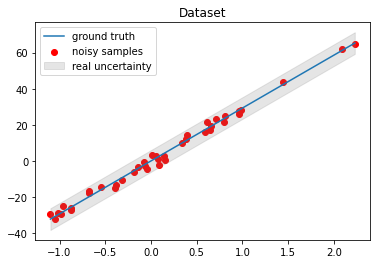

In [ ]:
grid = np.linspace(X.min(), X.max(), 1000)
plt.plot(grid, grid*coef, label='ground truth')
plt.scatter(X, y, c='r', label='noisy samples')
plt.fill_between(grid, grid*coef - 3*noise_std, grid*coef + 3*noise_std, 
                 alpha=0.2, color='grey', label='real uncertainty')
plt.title('Dataset')
plt.legend();

In [ ]:
num_models = 10
grid = np.linspace(-3, 3, 100)
means = np.zeros((num_models, len(grid)))
log_stds = np.zeros((num_models, len(grid)))

for model_idx in range(num_models):
  trainer = TrainerModule(hidden_dim=5, train_loader=train_loader, seed=model_idx, lr=0.05, eps=0.04)
  trainer.train_model(num_epochs=1000, visualize=False)
  mean, log_std = trainer.model.apply({'params': trainer.state.params}, grid.reshape(-1, 1))
  means[model_idx] = mean.flatten()
  log_stds[model_idx] = log_std.flatten()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

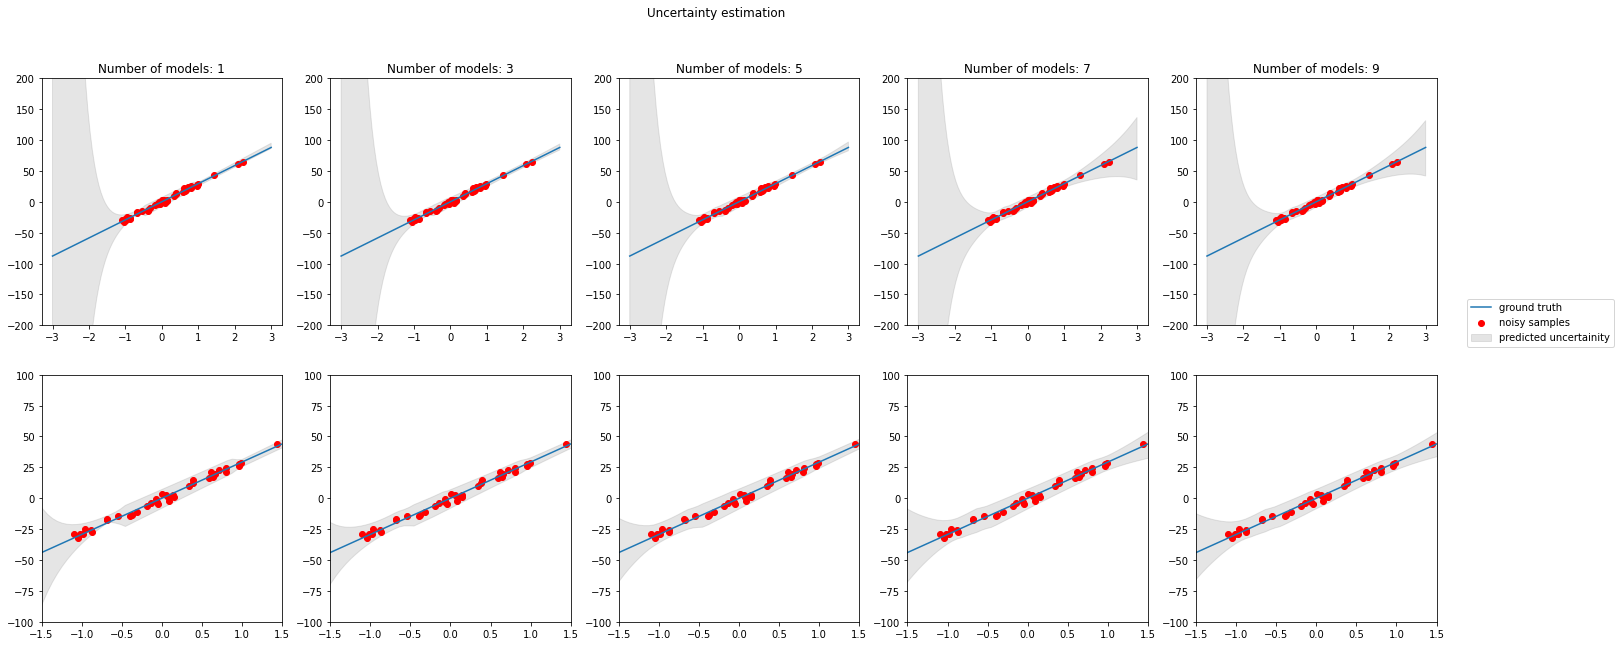

In [ ]:
fig = plt.figure(figsize=(25, 10))
fig.suptitle('Uncertainty estimation')
for i, n in enumerate(range(1, num_models, 2)):
  ensemble_mean = np.mean(means[:n], 0)
  ensemble_var = np.mean(np.exp(log_stds[:n])**2 + means[:n]**2, 0) - ensemble_mean**2

  plt.subplot(2, 5, i+1)
  plt.fill_between(grid, ensemble_mean - 3*np.sqrt(ensemble_var), ensemble_mean + 3*np.sqrt(ensemble_var), alpha=0.2, color='grey')
  plt.plot(grid, grid*coef)
  plt.scatter(X, y, c='r')
  plt.title('Number of models: {}'.format(n))
  plt.ylim([-200, 200])

  plt.subplot(2, 5, i+6)
  line_3 = plt.fill_between(grid, ensemble_mean - 3*np.sqrt(ensemble_var), ensemble_mean + 3*np.sqrt(ensemble_var), alpha=0.2, color='grey')
  line_1 = plt.plot(grid, grid*coef)
  line_2 = plt.scatter(X, y, c='r')
  plt.xlim([-1.5, 1.5])
  plt.ylim([-100, 100]);


fig.legend([line_1[0], line_2, line_3], ['ground truth', 'noisy samples', 'predicted uncertainty'], loc = 'right');

## Linear dataset (high level of noise)

In [ ]:
noise_std = 15
X, y, coef = make_regression(40, 1, noise=noise_std, coef=True)
train_data = data.TensorDataset(torch.tensor(X), torch.tensor(y))
train_loader = data.DataLoader(list(zip(X, y)), batch_size=16, shuffle=True, drop_last=True, collate_fn=numpy_collate)

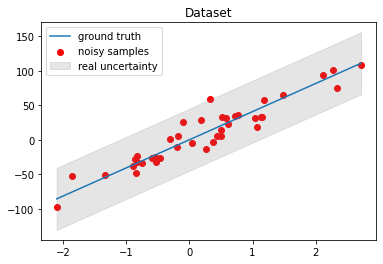

In [ ]:
grid = np.linspace(X.min(), X.max(), 1000)
plt.plot(grid, grid*coef, label='ground truth')
plt.scatter(X, y, c='r', label='noisy samples')
plt.fill_between(grid, grid*coef - 3*noise_std, grid*coef + 3*noise_std, 
                 alpha=0.2, color='grey', label='real uncertainty')
plt.title('Dataset')
plt.legend();

In [ ]:
num_models = 10
grid = np.linspace(-4, 4, 100)
means = np.zeros((num_models, len(grid)))
log_stds = np.zeros((num_models, len(grid)))

for model_idx in range(num_models):
  trainer = TrainerModule(hidden_dim=5, train_loader=train_loader, seed=model_idx, lr=0.03, eps=0.04)
  trainer.train_model(num_epochs=1000, visualize=False)
  mean, log_std = trainer.model.apply({'params': trainer.state.params}, grid.reshape(-1, 1))
  means[model_idx] = mean.flatten()
  log_stds[model_idx] = log_std.flatten()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

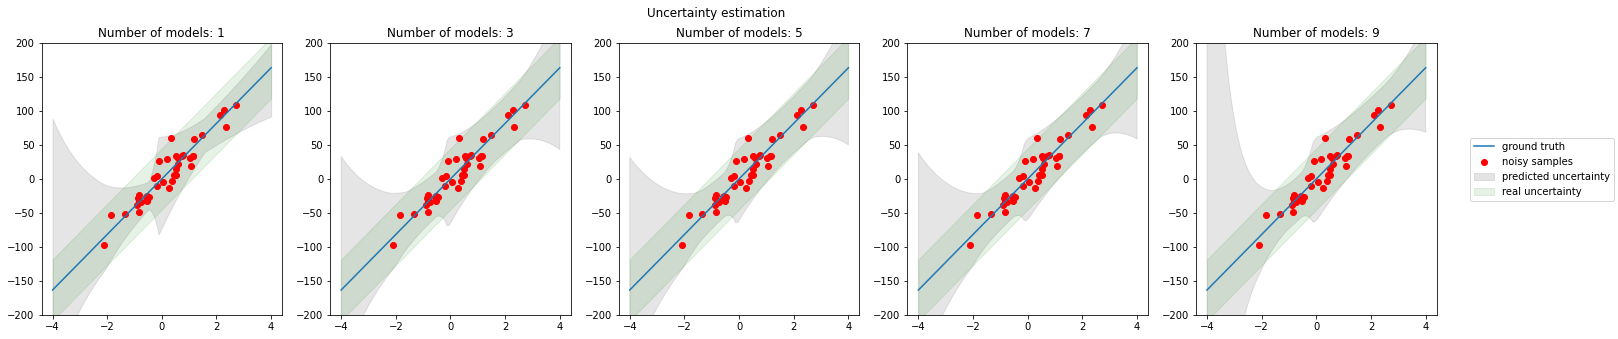

In [ ]:
fig = plt.figure(figsize=(25, 5))
fig.suptitle('Uncertainty estimation')
for i, n in enumerate(range(1, num_models, 2)):
  ensemble_mean = np.mean(means[:n], 0)
  ensemble_var = np.mean(np.exp(log_stds[:n])**2 + means[:n]**2, 0) - ensemble_mean**2

  plt.subplot(1, 5, i+1)
  line_3 = plt.fill_between(grid, ensemble_mean - 3*np.sqrt(ensemble_var), ensemble_mean + 3*np.sqrt(ensemble_var), alpha=0.2, color='grey')
  line_1 = plt.plot(grid, grid*coef)
  line_4 = plt.fill_between(grid, grid*coef - 3*noise_std, grid*coef + 3*noise_std, alpha=0.1, color='green')
  line_2 = plt.scatter(X, y, c='r')
  plt.title('Number of models: {}'.format(n))
  plt.ylim([-200, 200])


fig.legend([line_1[0], line_2, line_3, line_4], ['ground truth', 'noisy samples', 'predicted uncertainty', 'real uncertainty'], loc = 'right');

## Nonlinear dataset

In [ ]:
noise_std = 3
X = np.random.uniform(low=-5, high=5, size=40)
y = X**3 + np.random.normal(0, noise_std, size=40)

X=X.reshape(-1, 1)
train_data = data.TensorDataset(torch.tensor(X), torch.tensor(y))
train_loader = data.DataLoader(list(zip(X, y)), batch_size=16, shuffle=True, drop_last=True, collate_fn=numpy_collate)

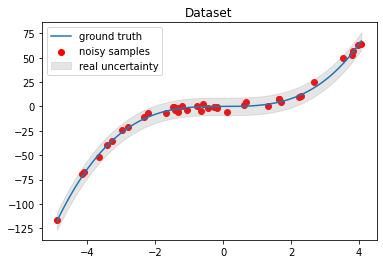

In [ ]:
grid = np.linspace(X.min(), X.max(), 1000)
plt.plot(grid, grid**3, label='ground truth')
plt.scatter(X, y, c='r', label='noisy samples')
plt.fill_between(grid, grid**3 - 3*noise_std, grid**3 + 3*noise_std, 
                 alpha=0.2, color='grey', label='real uncertainty')
plt.title('Dataset')
plt.legend();

In [ ]:
num_models = 10
grid = np.linspace(-7, 7, 100)
means = np.zeros((num_models, len(grid)))
log_stds = np.zeros((num_models, len(grid)))

for model_idx in range(num_models):
  trainer = TrainerModule(hidden_dim=5, train_loader=train_loader, seed=model_idx, lr=0.03, eps=0.08)
  trainer.train_model(num_epochs=10000, visualize=False)
  mean, log_std = trainer.model.apply({'params': trainer.state.params}, grid.reshape(-1, 1))
  means[model_idx] = mean.flatten()
  log_stds[model_idx] = log_std.flatten()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

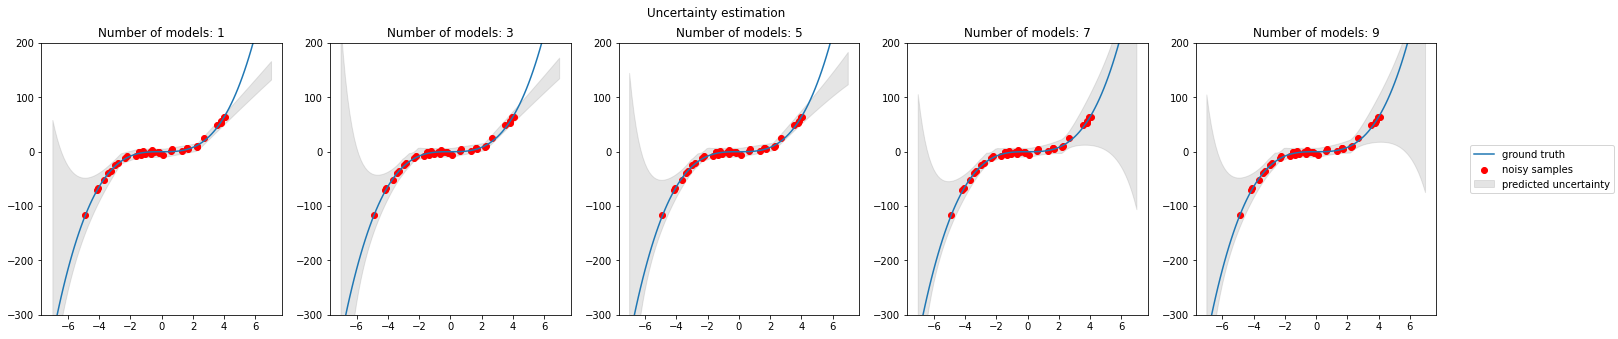

In [ ]:
fig = plt.figure(figsize=(25, 5))
fig.suptitle('Uncertainty estimation')
for i, n in enumerate(range(1, num_models, 2)):
  ensemble_mean = np.mean(means[:n], 0)
  ensemble_var = np.mean(np.exp(log_stds[:n])**2 + means[:n]**2, 0) - ensemble_mean**2

  plt.subplot(1, 5, i+1)
  line_3 = plt.fill_between(grid, ensemble_mean - 3*np.sqrt(ensemble_var), ensemble_mean + 3*np.sqrt(ensemble_var), alpha=0.2, color='grey')
  line_1 = plt.plot(grid, grid**3)
  line_2 = plt.scatter(X, y, c='r')
  plt.title('Number of models: {}'.format(n))
  plt.ylim([-300, 200])

fig.legend([line_1[0], line_2, line_3], ['ground truth', 'noisy samples', 'predicted uncertainty'], loc = 'right');

**Results**


*   Ensemble combination improves performance, especially as we move farther from the observed training data
*   Uncertainty estimation improves when we use more models
*   For the considered datasets: it is sufficient to use 7 models


